In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Keras
from keras.models import Model, Sequential
from keras import utils
from keras.preprocessing import image

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Сторонние либы
import time
import os
from PIL import Image

#Базовые слои
from keras.layers import Input, concatenate, Activation, Reshape, Flatten, Dense, LSTM, GRU

#Оптимизаторы
from tensorflow.keras.optimizers import Adam
#Свертка
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from keras.layers import Conv1DTranspose, Conv2DTranspose, Conv3DTranspose
from keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, GlobalMaxPooling3D

#Регуляризация
from keras.layers import Dropout, BatchNormalization
from keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def Autoencoder(shape=(112,80,1)):
    img_input = Input((shape))
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    z = MaxPooling2D()(x)
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)


    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error')

    return model

In [4]:
def load_images(images_dir, img_height, img_width): 
  list_images = []
  for img in os.listdir(images_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images)

def plotImages(xTrain, pred, shape=(112, 80)):
  n = 5
  plt.figure(figsize=(10, 4))
  for i in range(n):
      index = np.random.randint(0, pred.shape[0])
      
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(xTrain[index].reshape(shape))     
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(pred[index].reshape(shape))   
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

def getMSE(x1, x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  return sum(delta ** 2) / len(delta)

In [5]:
images_dir = '/content/drive/MyDrive/PythonCode/УИИ/9 (AE)/Лица'
img_height = 112
img_width = 80
x_train = load_images(images_dir, img_height, img_width)
x_train = x_train / 255
x_train.shape

(5018, 112, 80, 1)

In [9]:
modelName = Autoencoder()
modelName.fit(x_train[:4700],
          x_train[:4700],
          epochs=150,
          batch_size=128,
          validation_data=(x_train[4700:], x_train[4700:]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
37/37 [==============================] - 24s 288ms/step - loss: 0.0513 - val_loss: 0.0601
Epoch 2/150
37/37 [==============================] - 8s 222ms/step - loss: 0.0149 - val_loss: 0.0594
Epoch 3/150
37/37 [==============================] - 8s 223ms/step - loss: 0.0088 - val_loss: 0.0583
Epoch 4/150
37/37 [==============================] - 8s 225ms/step - loss: 0.0067 - val_loss: 0.0568
Epoch 5/150
37/37 [==============================] - 8s 226ms/step - loss: 0.0057 - val_loss: 0.0549
Epoch 6/150
37/37 [==============================] - 8s 229ms/step - loss: 0.0050 - val_loss: 0.0512
Epoch 7/150
37/37 [==============================] - 8s 227ms/step - loss: 0.0047 - val_loss: 0.0483
Epoch 8/150
37/37 [==============================] - 8s 226ms/step - loss: 0.0043 - val_loss: 0.0404
Epoch 9/150
37/37 [==============================] - 8s 228ms/step - loss: 0.0040 - val_loss: 0.0346
Epoch 10/150
37/37 [==============================] - 8s 229ms/step - loss: 0.0038 - val_l

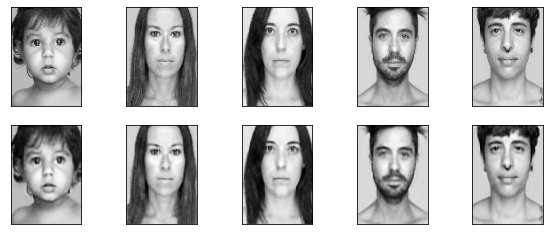

In [11]:
pred = modelName.predict(x_train[:100])
pred = pred * 255 
plotImages(x_train, pred)

In [12]:
errFace = [getMSE(x_train[i], pred[i] / 255) for i in range(len(pred))]
print('Ошибка на последних 20 лицах:', errFace[:20])
print('Средняя ошибка:', round(sum(errFace[80:]) / len(errFace[80:]), 4))
print("Минимальная ошибка на Лицах:", round(min(errFace), 4))
print("Максимальная ошибка на Лицах:", round(max(errFace), 4))

Ошибка на последних 20 лицах: [0.008816476073373975, 0.0008106360412861022, 0.001957352897091168, 0.0016766640105793226, 0.004291245429385062, 0.0009280541135960401, 0.0007841764609998812, 0.0034349493310945646, 0.0015042270305892535, 0.0005743539241831493, 0.001137308910678613, 0.00304355076815163, 0.0012335446383693897, 0.001461410821252124, 0.001925516147614248, 0.0014723253023072032, 0.0015405490129502312, 0.0010199246485352884, 0.0025828193702388965, 0.001155608255432719]
Средняя ошибка: 0.0015
Минимальная ошибка на Лицах: 0.0006
Максимальная ошибка на Лицах: 0.0088


In [14]:
bias = 0.0016

isFace = [e < bias for e in errFace]

print("Лица распознаны, как Лица: ", round(100*sum(isFace) / len(isFace)),"%", sep="")

Лица распознаны, как Лица: 85%
